Basic Kaggle warmup - the Titanic dataset

In [1]:
###!pip3 install pandas
###!pip3 install seaborn
###!pip3 install sklearn

In [2]:
# Get the data!
import numpy as np 
import pandas as pd 

from os import path

%matplotlib inline
import matplotlib.pyplot as plt

data_dir = "./data/"
train = pd.read_csv(path.join(data_dir,"train.csv"))
test = pd.read_csv(path.join(data_dir,"test.csv"))


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.describe(include=[ 'O' ])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Meanwell, Miss. (Marion Ogden)",male,347082,G6,S
freq,1,577,7,4,644


In [5]:
# Cabin looks pretty useless as it has so many nulls
# PassengerId and Ticket also not useful.

# fare and age have nulls but we can use medians there
for dataset in [train, test]:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    # Name is probably pretty useless too, but other Kaggle folks suggest the title is relevant, so extract that then drop the name.
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    dataset.drop(['PassengerId','Cabin', 'Ticket', 'Name'], axis=1, inplace = True)
    


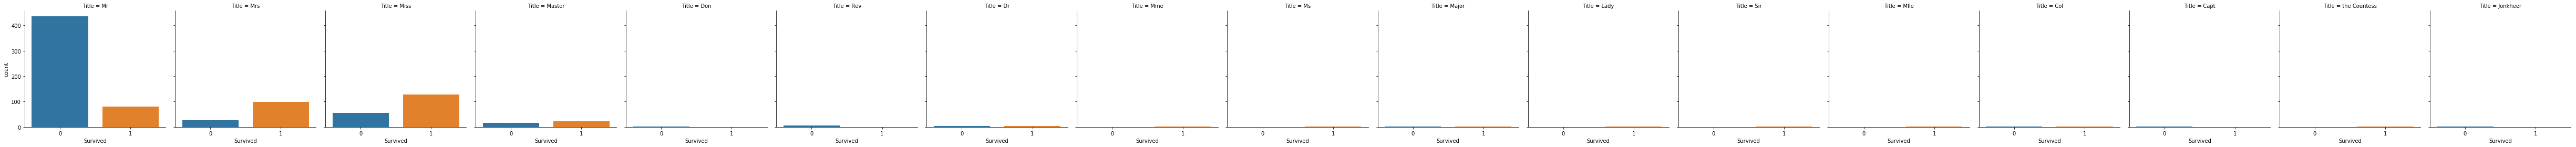

In [6]:
# Verify that title is relevant
import seaborn as sns

sns.factorplot(x='Survived', col='Title', kind='count', data=train);
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Embarked    418 non-null object
Title       418 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB


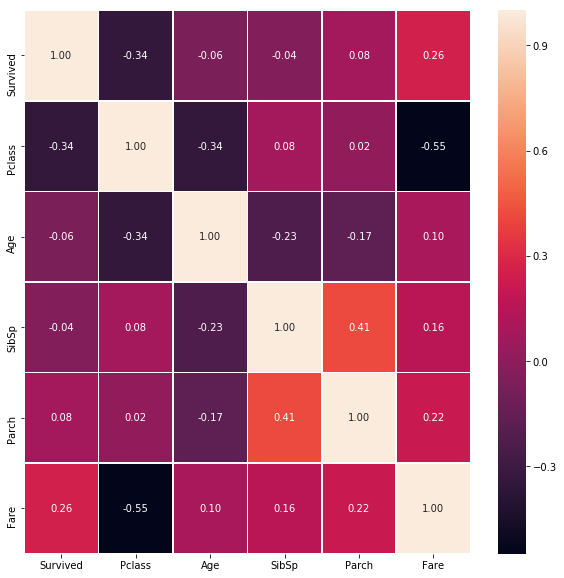

In [7]:
test.info()
test.head()

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True, linewidths=0.5, fmt='.2f',ax=ax)
plt.show()


In [8]:
# Parch and SibSP seem useless
train = train.drop(['Parch', 'SibSp'], axis=1)
test = test.drop(['Parch', 'SibSp'], axis=1)


In [32]:
# Convert categorical data to meaningful numeric

def fixCategoricals(dataset):
    dummies = []
    cols = ['Sex', 'Embarked', 'Title']
    for col in cols:
        dummies.append(pd.get_dummies(dataset[col]))

    titanic_dummies = pd.concat(dummies, axis=1)
    dataset = pd.concat((dataset, titanic_dummies), axis=1)
    dataset = dataset.drop(['Sex', 'Embarked', 'Title'], axis=1)
    
    return dataset

In [38]:
train = fixCategoricals(train)
test = fixCategoricals(test)
    
# test set will end up with fewer title columns...
cols_in_train = list(train)
cols_in_test = list(test)

for c in cols_in_train:
    if c not in cols_in_test:
        test[c] = 0

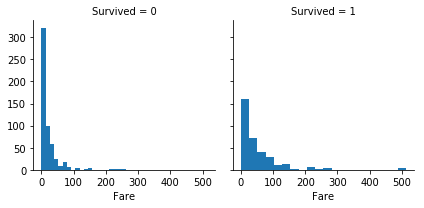

In [39]:
# Take a look at what's left
grid = sns.FacetGrid(train, col='Survived')
grid.map(plt.hist, 'Fare', bins=20)

In [40]:
test.head()

,Pclass,Age,Fare,Survived,female,male,C,Q,S,Col,...,Rev,Capt,Don,Jonkheer,Lady,Major,Mlle,Mme,Sir,the Countess
0,3,34.5,7.8292,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,47.0,7.0000,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,62.0,9.6875,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,27.0,8.6625,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,22.0,12.2875,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
data_columns = list(train)[1:]

In [42]:
# Apparently XGB is the one everyone uses :-)
from sklearn import model_selection, ensemble


rfc = ensemble.RandomForestClassifier()
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )
cv_results = model_selection.cross_validate(rfc, train[data_columns], train["Survived"], cv  = cv_split)

cv_results

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.04057312, 0.02828312, 0.02853513, 0.09102201, 0.02325106,
        0.02902913, 0.02305675, 0.02912474, 0.02341199, 0.02714491]),
 'score_time': array([0.00494194, 0.00321698, 0.00290275, 0.00283504, 0.00226784,
        0.00228691, 0.00446391, 0.00267529, 0.0026989 , 0.002321  ]),
 'test_score': array([0.80597015, 0.79850746, 0.80223881, 0.79477612, 0.83208955,
        0.78358209, 0.77985075, 0.77238806, 0.83208955, 0.86567164]),
 'train_score': array([0.9588015 , 0.97752809, 0.96441948, 0.96816479, 0.97191011,
        0.96254682, 0.96629213, 0.95692884, 0.96254682, 0.9588015 ])}

In [48]:
rfc.fit(train[data_columns], train["Survived"])
results = rfc.predict(test[data_columns])

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [59]:
test2 = pd.read_csv(path.join(data_dir,"test.csv"))
temp = pd.DataFrame({'PassengerId':test2['PassengerId'], 'Survived':results})

temp.to_csv("../submission.csv", index = False)